In [120]:
!pip install neuralforecast

In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import month_plot
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from prophet import Prophet
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS
import pickle

ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 447, in run
    conflicts = self._determine_conflicts(to_install)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 578, in _determine_conflicts
    return check_install_conflicts(to_install)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/operations/check.py", line 101, in check_install_conflicts
    package_set, _ = create_package_

Plotting function

In [2]:
def plot_model_forecast(title, train, test, forecast, model_name):
    """
    Plot train, test, and forecast for a single model, and compute RMSE + MAE.

    Parameters:
    ----------
    title : str
        Plot title.
    train : pd.Series
        Training data.
    test : pd.Series
        Testing data.
    forecast : pd.Series or np.array
        Forecasted values for the test period.
    model_name : str
        Name of the model (for labeling).

    Returns:
    -------
    metrics : dict
        Dictionary with RMSE and MAE.
    """
    plt.figure(figsize=(12,6))

    # Plot train and test
    plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Test', color='black')

    # Plot forecast
    plt.plot(test.index, forecast, label=f'{model_name} Forecast')

    plt.legend()
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Weekly Sales')
    plt.show()

    # Compute metrics
    # Calculate MSE first
    mse = mean_squared_error(test, forecast)
    # Then calculate RMSE manually by taking the square root of MSE
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(test, forecast)

    # Print metrics
    print(f"{model_name} — RMSE: {rmse:.2f}, MAE: {mae:.2f}")

    return {'RMSE': rmse, 'MAE': mae}

In [3]:
df = pd.read_csv('/content/Walmart_department_27.csv')

In [4]:
df.reset_index(drop=True, inplace=True)
df.drop(columns=['Dept'], inplace=True)

In [ ]:
df.head()

,Date,IsHoliday,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment
0,2010-02-05,0,2293.00,42.31,2.572,211.096358,8.106
1,2010-02-12,1,2339.50,38.51,2.548,211.242170,8.106
2,2010-02-19,0,2494.50,39.93,2.514,211.289143,8.106
3,2010-02-26,0,1666.75,46.63,2.561,211.319643,8.106
4,2010-03-05,0,1467.50,46.50,2.625,211.350143,8.106


# **EDA**

In [ ]:
df.shape

(143, 7)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          143 non-null    object 
 1   IsHoliday     143 non-null    int64  
 2   Weekly_Sales  143 non-null    float64
 3   Temperature   143 non-null    float64
 4   Fuel_Price    143 non-null    float64
 5   CPI           143 non-null    float64
 6   Unemployment  143 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 7.9+ KB


In [ ]:
df.describe(include='all') # To include columns from type 'Object'

,Date,IsHoliday,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment
count,143,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000
unique,143,NaN,NaN,NaN,NaN,NaN,NaN
top,2010-02-05,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,0.069930,1374.649650,68.306783,3.219699,215.996892,7.610420
std,NaN,0.255926,687.905199,14.250486,0.427313,4.350890,0.383749
min,NaN,0.000000,623.570000,35.400000,2.514000,210.337426,6.573000
25%,NaN,0.000000,944.150000,58.265000,2.764500,211.549277,7.348000
50%,NaN,0.000000,1167.000000,69.640000,3.290000,215.459905,7.787000
75%,NaN,0.000000,1624.305000,80.485000,3.594000,220.531330,7.838000


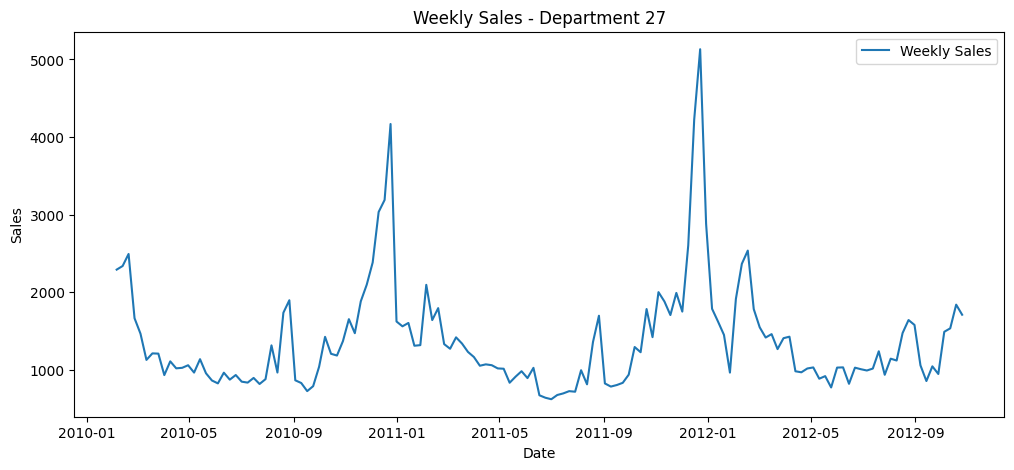

In [ ]:
# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Plot Weekly_Sales
plt.figure(figsize=(12, 5))
plt.plot(df['Date'], df['Weekly_Sales'], label='Weekly Sales')
plt.title(f'Weekly Sales - Department 27')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

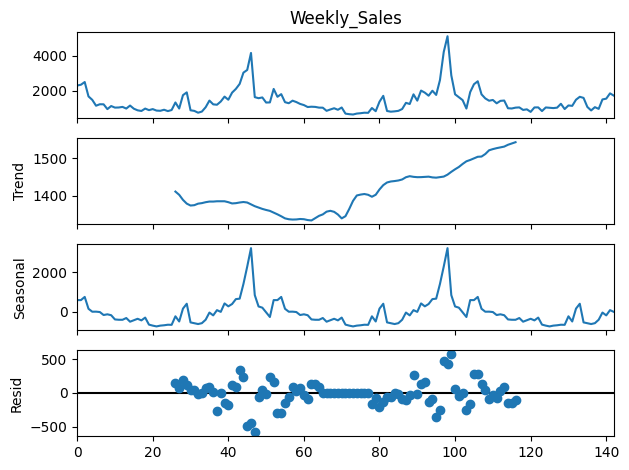

In [ ]:
result = seasonal_decompose(df['Weekly_Sales'], model='additive', period=52)

result.plot()
plt.show()

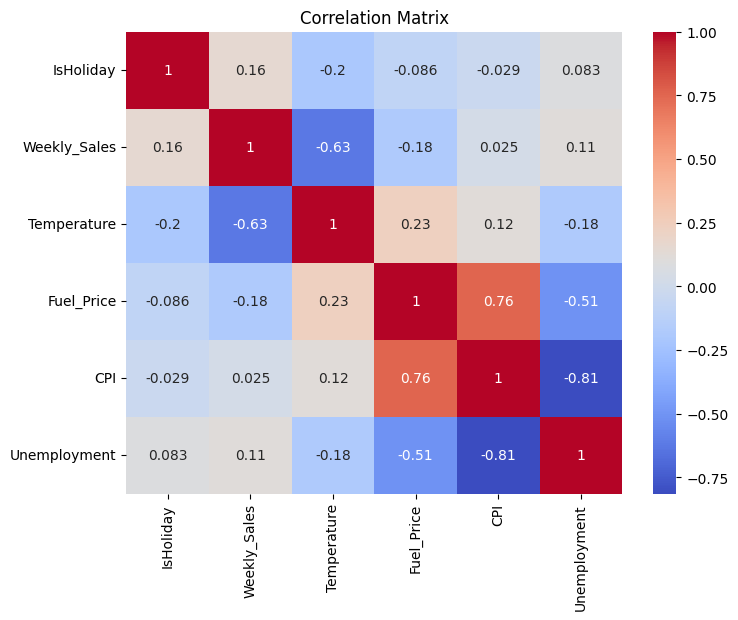

In [ ]:
# 'Date' convert from string
cols = ['IsHoliday','Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
corr = df[cols].corr()

# Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

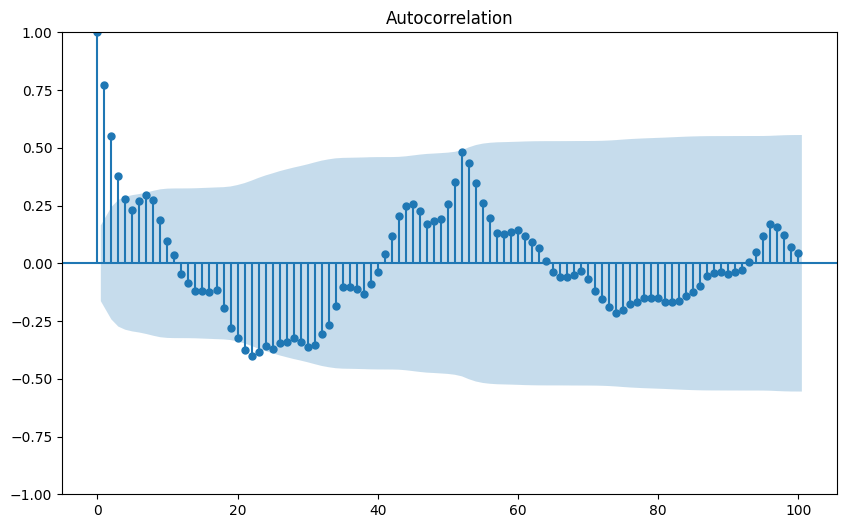

In [ ]:
fig, ax = plt.subplots(figsize = (10,6))
plot_acf(df['Weekly_Sales'], lags = 100, ax = ax)
plt.show()

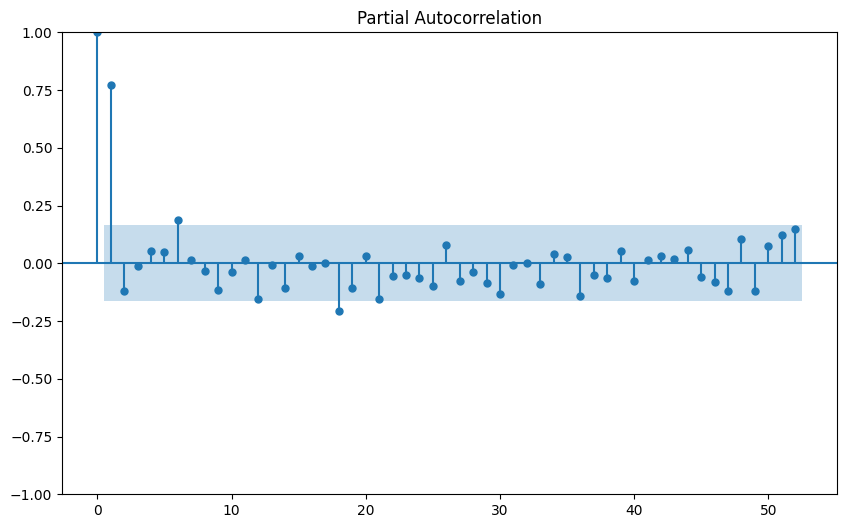

In [ ]:
fig, ax = plt.subplots(figsize = (10,6))
plot_pacf(df['Weekly_Sales'], lags = 52, ax = ax)
plt.show()

> # **Splitting the data into 20% training (30 rows for testing and 110 for training) and evaluating all models accordingly**

In [ ]:
testing_portion=30
train = df['Weekly_Sales'].iloc[:-testing_portion]
test = df['Weekly_Sales'].iloc[-testing_portion:]

# **Holt-Winters and Holt-Linear Trend**

In [ ]:
# Fitting the models

#Holt linear model
holt_model = ExponentialSmoothing(train, trend='add', seasonal=None).fit()
holt_forecast = holt_model.forecast(len(test))

#Holt-Winters (additive seasonality)
hw_model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=52).fit()
hw_forecast = hw_model.forecast(len(test))

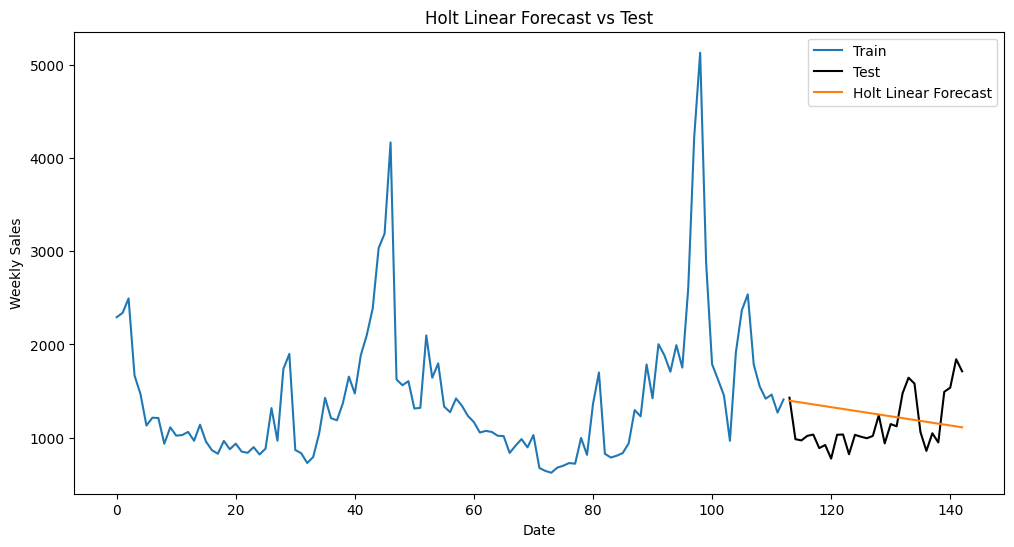

Holt Linear — RMSE: 354.11, MAE: 314.54


In [ ]:
metrics_holt = plot_model_forecast(
    title='Holt Linear Forecast vs Test',
    train=train,
    test=test,
    forecast=holt_model.forecast(len(test)),
    model_name='Holt Linear'
)

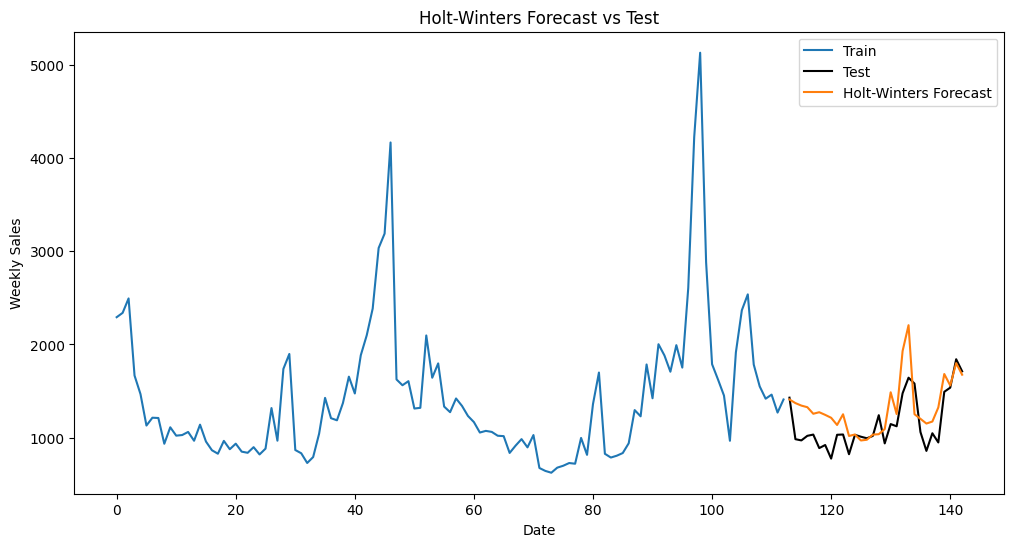

Holt-Winters — RMSE: 265.32, MAE: 215.23


In [ ]:
metrics_hw = plot_model_forecast(
    title='Holt-Winters Forecast vs Test',
    train=train,
    test=test,
    forecast=hw_forecast,
    model_name='Holt-Winters'
)

# ACF + PACF suggest non-stationarity, so there is a need for differencing the series before handeling it to the...

# **ARIMA models family**

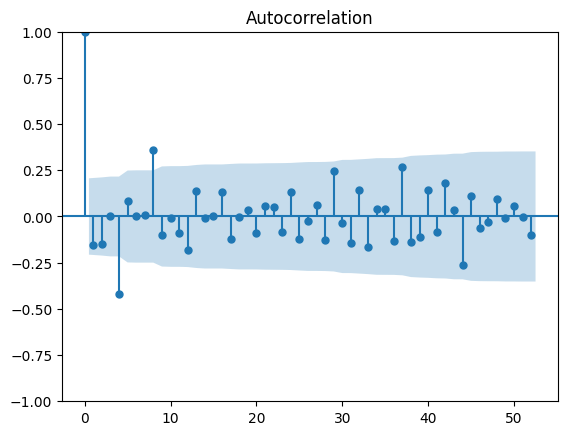

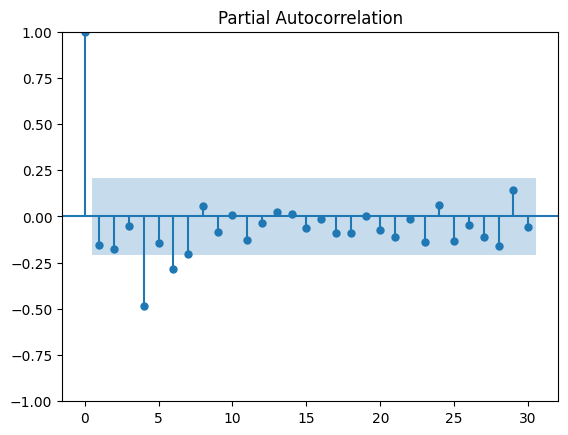

In [ ]:
# First difference (if trend)
diff_series = df['Weekly_Sales'].diff().dropna()

# Seasonal difference (if seasonality seen at lag 52)
diff_series = diff_series.diff(52).dropna()

plot_acf(diff_series, lags=52)
plt.show()

plot_pacf(diff_series, lags=30)
plt.show()


In [ ]:
# ARIMA models (SARIMAX without seasonal_order)
arima_model = SARIMAX(df['Weekly_Sales'], order=(3,1,2))
arima_fit = arima_model.fit()

# Forecast next 52 weeks
arima_forecast = arima_fit.forecast(52)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels

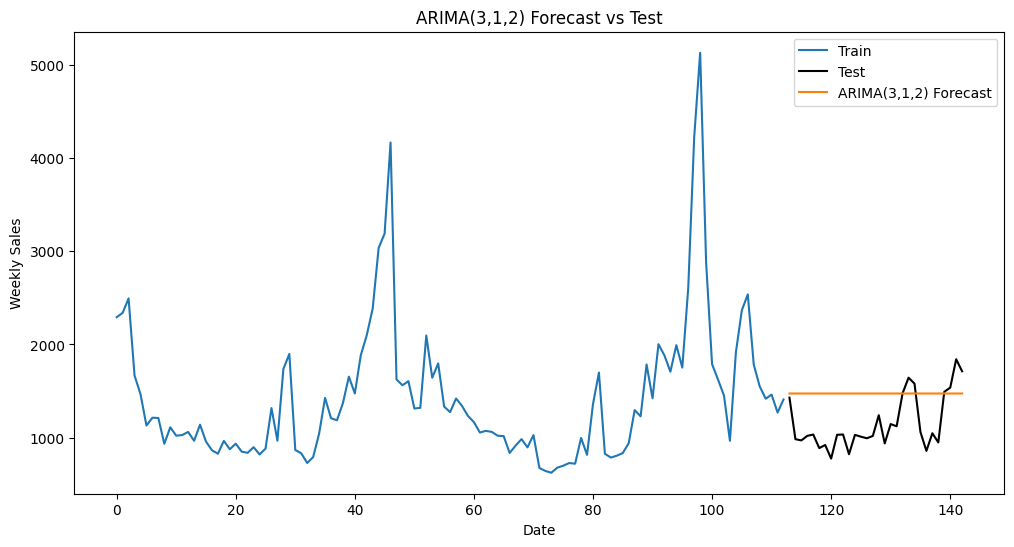

ARIMA(3,1,2) — RMSE: 428.87, MAE: 384.86


In [ ]:
metrics_arima = plot_model_forecast(
    title='ARIMA(3,1,2) Forecast vs Test',
    train=train,
    test=test,
    forecast=arima_forecast2.iloc[-len(test):],
    model_name='ARIMA(3,1,2)'
)

In [ ]:
sarima_model = SARIMAX(train, order=(2,1,2), seasonal_order=(1,0,1,52))
sarima_fit = sarima_model.fit()

sarima_forecast = sarima_fit.forecast(len(test))
sarima_forecast.index = test.index  # align forecast index to test index

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


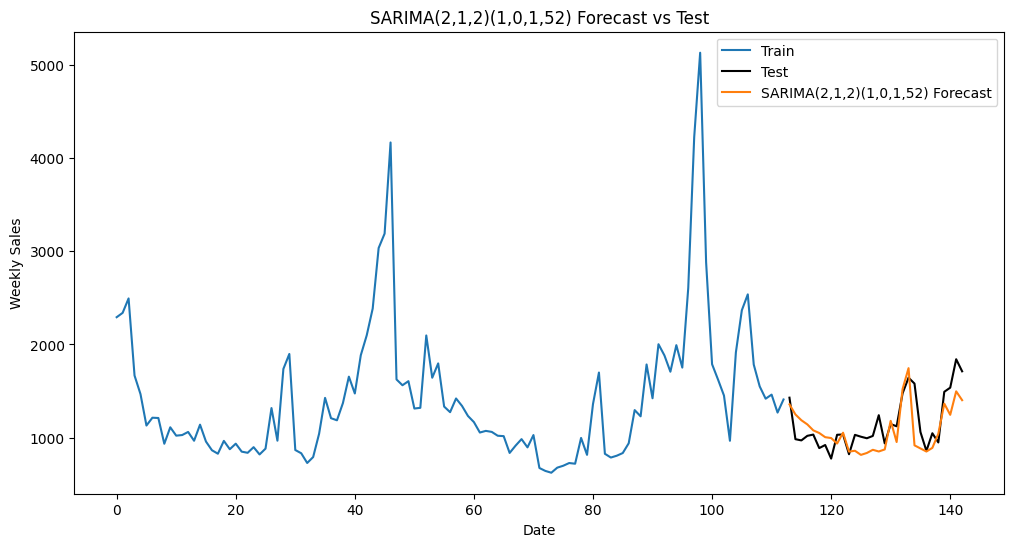

SARIMA(2,1,2)(1,0,1,52) — RMSE: 213.22, MAE: 165.94


In [ ]:
metrics_sarima = plot_model_forecast(
    title='SARIMA(2,1,2)(1,0,1,52) Forecast vs Test',
    train=train,
    test=test,
    forecast=sarima_forecast,
    model_name='SARIMA(2,1,2)(1,0,1,52)'
)

# **Machine learning models**

In [80]:
# Time series feature engineering
# Lag feature: previous week's sales
df['lag1'] = df['Weekly_Sales'].shift(1)

# Lag feature: sales from two weeks ago
df['lag2'] = df['Weekly_Sales'].shift(2)

# Rolling mean: average sales over the past 4 weeks
df['rolling_mean_4'] = df['Weekly_Sales'].rolling(window=4).mean()

# Rolling std: sales variability over the past 4 weeks
df['rolling_std_4'] = df['Weekly_Sales'].rolling(window=4).std()

# Drop missing rows (due to lag/rolling)
df = df.dropna()

# Define X and y
features = ['lag1', 'lag2', 'rolling_mean_4', 'rolling_std_4',
            'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
            'IsHoliday']

X = df[features]
y = df['Weekly_Sales']

In [ ]:
testing_portion = 30
X_train, X_test = X.iloc[:-testing_portion], X.iloc[-testing_portion:]
y_train, y_test = y.iloc[:-testing_portion], y.iloc[-testing_portion:]

In [ ]:
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

In [ ]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

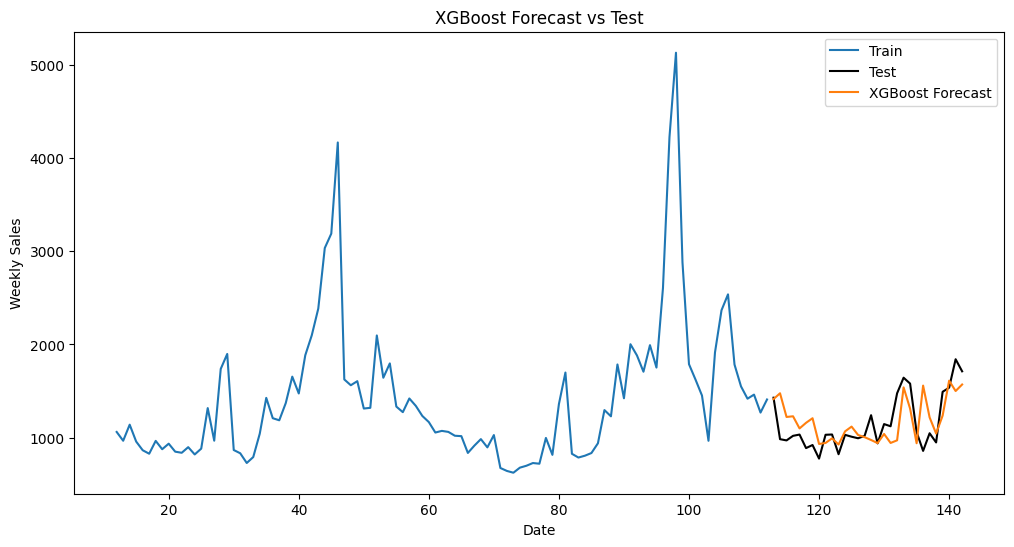

XGBoost — RMSE: 243.16, MAE: 183.70


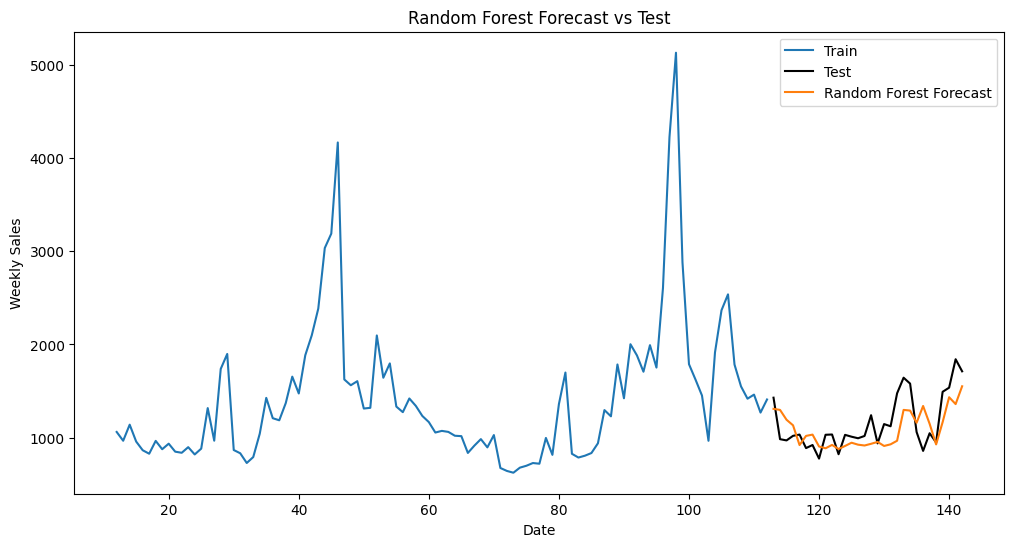

Random Forest — RMSE: 229.62, MAE: 186.40


In [ ]:
metrics_xgb = plot_model_forecast(
    title='XGBoost Forecast vs Test',
    train=y_train,
    test=y_test,
    forecast=pd.Series(y_pred_xgb, index=y_test.index),
    model_name='XGBoost'
)

metrics_rf = plot_model_forecast(
    title='Random Forest Forecast vs Test',
    train=y_train,
    test=y_test,
    forecast=pd.Series(y_pred_rf, index=y_test.index),
    model_name='Random Forest'
)

# **Deep Learning models**

In [ ]:
# MLP model
model_mlp = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])

model_mlp.compile(optimizer='adam', loss='mse')
model_mlp.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 3971205.0000 - val_loss: 1734161.3750
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2858133.0000 - val_loss: 1157013.7500
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1872810.5000 - val_loss: 739745.4375
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1177707.2500 - val_loss: 447095.4688
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 805661.3125 - val_loss: 244862.3438
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 559780.5000 - val_loss: 121110.5703
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 329636.6250 - val_loss: 67658.5703
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 400708.4375 - val_loss: 56364.9844
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 306557.8438 - val_loss: 58009.5742
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 379811.5625 - val_loss: 57187.2539
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 379461.9375 - val_lo

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


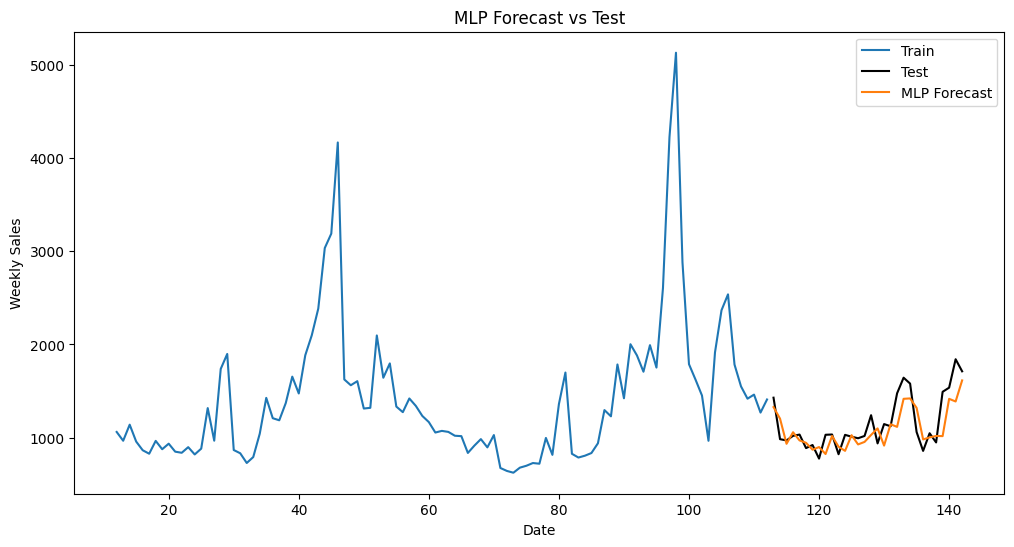

MLP — RMSE: 187.13, MAE: 144.20


In [ ]:

y_pred_mlp = model_mlp.predict(X_test).flatten()

metrics_mlp = plot_model_forecast(
    title='MLP Forecast vs Test',
    train=y_train,
    test=y_test,
    forecast=pd.Series(y_pred_mlp, index=y_test.index),
    model_name='MLP'
)

In [98]:
testing_portion = 30
train_p = df_prophet.iloc[:-testing_portion].copy() #.copy() to avoid SettingWithCopyWarning
test_p = df_prophet.iloc[-testing_portion:].copy()

X_train = train_df[features]
y_train = train_df['Weekly_Sales']

X_test = test_df[features]
y_test = test_df['Weekly_Sales']


X_train = X_train.drop(columns=['Date'], errors='ignore')
X_test = X_test.drop(columns=['Date'], errors='ignore')

# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_seq = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_seq = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

model_lstm = Sequential([
    LSTM(128, activation='relu', return_sequences=True, input_shape=(1, X_train.shape[1])),
    LSTM(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

opt = Adam(learning_rate=0.01)
model_lstm.compile(optimizer=opt, loss='mse')

history = model_lstm.fit(
    X_train_seq, y_train,
    epochs=50,
    validation_data=(X_test_seq, y_test),
    verbose=1
)

y_pred_lstm = model_lstm.predict(X_test_seq).flatten()

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 265ms/step - loss: 2589014.7500 - val_loss: 1409183.8750
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 2785236.2500 - val_loss: 1395750.1250
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 2379493.7500 - val_loss: 1330362.1250
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 2412805.5000 - val_loss: 1140268.6250
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 2256788.0000 - val_loss: 795035.6875
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1431424.6250 - val_loss: 278955.9062
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 936974.8750 - val_loss: 85233.7344
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1000280.6875 - val_loss: 224811.9219
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 964885.4375 - val_loss: 182118.2031
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 596773.0625 - val_loss: 238558.0938
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 554254.4375

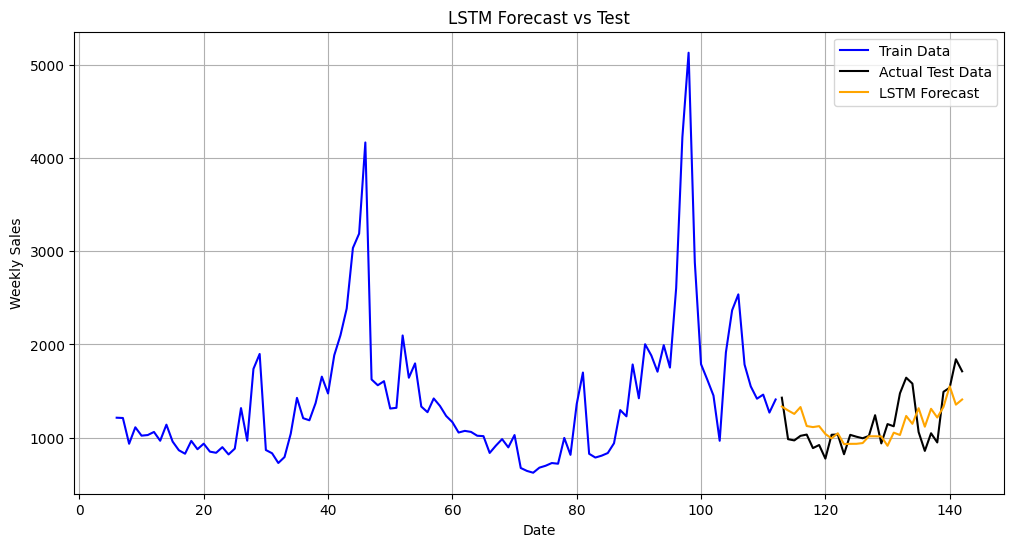

LSTM Metrics:
  MAE: 202.48
  RMSE: 243.72


In [99]:
metrics_lstm = plot_model_forecast(
    title='LSTM Forecast vs Test',
    train=y_train,
    test=y_test,
    forecast=pd.Series(y_pred_lstm, index=y_test.index),
    model_name='LSTM'
)

# **Prophet model**

In [57]:
# Prophet model
df_prophet = df.reset_index()[['Date', 'Weekly_Sales']].rename(columns={'Date': 'ds', 'Weekly_Sales': 'y'})

testing_portion = 30
train_p = df_prophet.iloc[:-testing_portion].copy() #.copy() to avoid SettingWithCopyWarning
test_p = df_prophet.iloc[-testing_portion:].copy()

prophet_model = Prophet()
prophet_model.fit(train_p)

future = test_p[['ds']]

forecast = prophet_model.predict(future)
prophet_forecast = forecast['yhat']
prophet_forecast.index = test.index

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2hrrv4yf/vyycg_zu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2hrrv4yf/w04bpgcr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31729', 'data', 'file=/tmp/tmp2hrrv4yf/vyycg_zu.json', 'init=/tmp/tmp2hrrv4yf/w04bpgcr.json', 'output', 'file=/tmp/tmp2hrrv4yf/prophet_model0x3fwnxc/prophet_model-20250622183418.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:34:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:34:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


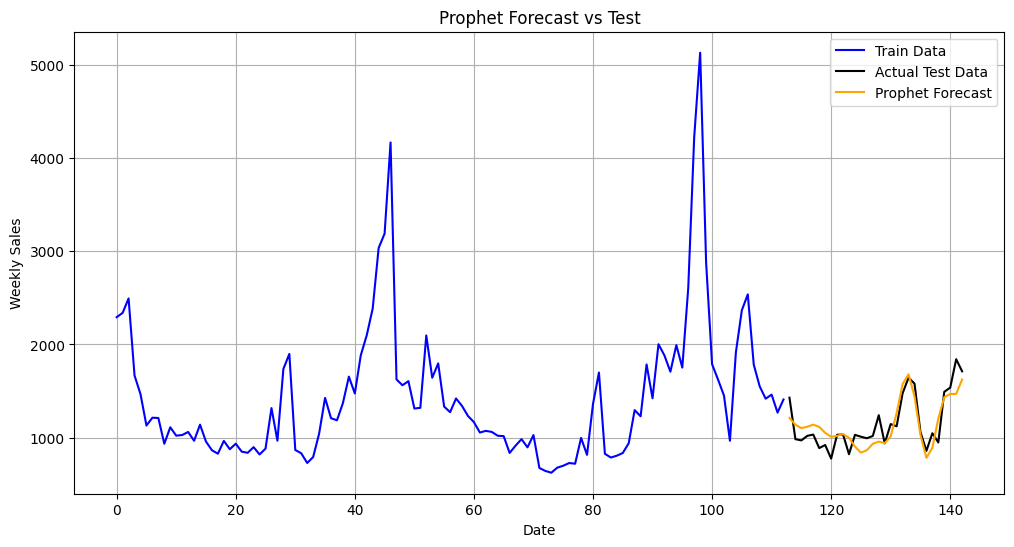

Prophet Metrics:
  MAE: 131.36
  RMSE: 156.24


In [55]:
metrics_prophet = plot_model_forecast(
    title='Prophet Forecast vs Test',
    train=train,
    test=test,
    forecast=prophet_forecast,
    model_name='Prophet'
)

# **Inovative technique (N-Beats)**

In [108]:
df_nf = df.reset_index()[['Date', 'Weekly_Sales']].rename(columns={'Date': 'ds', 'Weekly_Sales': 'y'})

df_nf['ds'] = pd.to_datetime(df_nf['ds'])

df_nf['unique_id'] = '1'

periods = len(test)

nbeats = NBEATS(h=periods, input_size=20,max_steps =300)

nf = NeuralForecast(models=[nbeats], freq='W')

nf.fit(df_nf)

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
3.1 K     Non-trainable params
2.5 M     Total params
9.950     Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=300` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

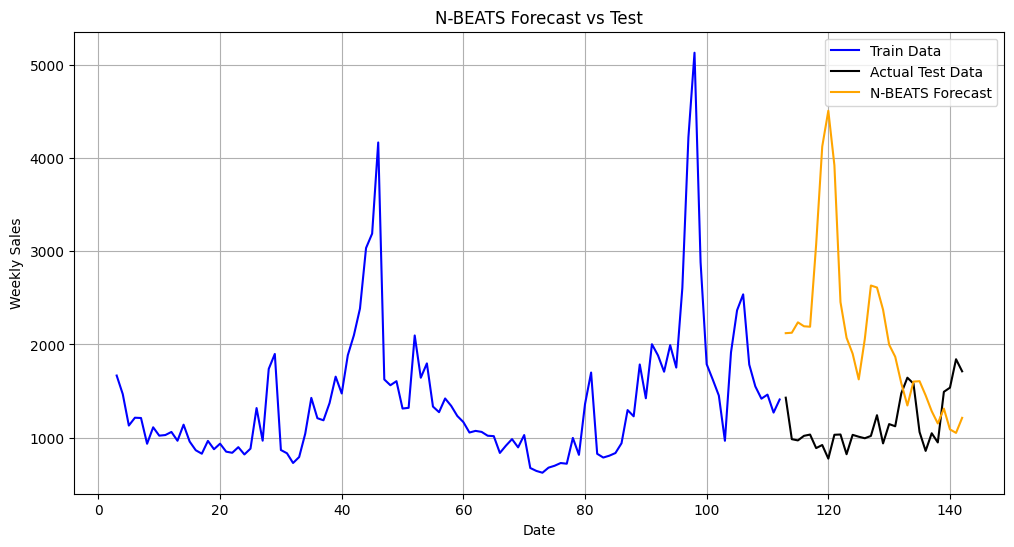

N-BEATS Metrics:
  MAE: 1087.43
  RMSE: 1403.73


In [110]:
# After predict()
forecast_df = nf.predict()

# Get the NBEATS forecast values
nbeats_forecast_values = forecast_df['NBEATS'].values

# Create a Series with test index
nbeats_forecast = pd.Series(nbeats_forecast_values, index=test.index)

# Plot using your function
metrics_nbeats = plot_model_forecast(
    title='N-BEATS Forecast vs Test',
    train=train,
    test=test,
    forecast=nbeats_forecast,
    model_name='N-BEATS'
)


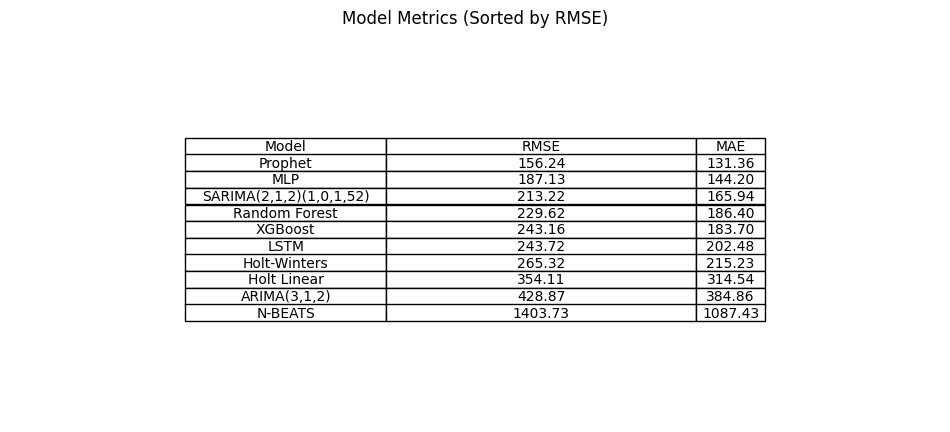

In [118]:
# metrics as dict
all_metrics = {
    'Holt Linear': {'RMSE': 354.11, 'MAE': 314.54},
    'Holt-Winters': {'RMSE': 265.32, 'MAE': 215.23},
    'ARIMA(3,1,2)': {'RMSE': 428.87, 'MAE': 384.86},
    'SARIMA(2,1,2)(1,0,1,52)': {'RMSE': 213.22, 'MAE': 165.94},
    'XGBoost': {'RMSE': 243.16, 'MAE': 183.70},
    'Random Forest': {'RMSE': 229.62, 'MAE': 186.40},
    'MLP': {'RMSE': 187.13, 'MAE': 144.20},
    'LSTM': {'RMSE': 243.72, 'MAE': 202.48},
    'Prophet': {'RMSE': 156.24, 'MAE': 131.36},
    'N-BEATS': {'RMSE': 1403.73,'MAE': 1087.43 }
}

# Sort by RMSE ascending
sorted_metrics = sorted(all_metrics.items(), key=lambda x: x[1]['RMSE'])

# Prepare table data
table_data = [
    [model, f"{metrics['RMSE']:.2f}", f"{metrics['MAE']:.2f}"]
    for model, metrics in sorted_metrics
]

# Plot the table
fig, ax = plt.subplots(figsize=(12, 5))
ax.axis('off')
table = ax.table(
    cellText=table_data,
    colLabels=["Model", "RMSE", "MAE"],
    cellLoc='center',
    loc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width([0, 4, 2])

plt.title("Model Metrics (Sorted by RMSE)", fontsize=12, pad=10)
plt.show()


# *So clearly Prophet is the model with the best performance🫡*

In [123]:
with open('prophet_model.pkl', 'wb') as f:
    pickle.dump(prophet_model, f)

# Load later
with open('prophet_model.pkl', 'rb') as f:
    loaded_prophet = pickle.load(f)


#**By Salma Basem Elfeel**


